In [1]:
import matplotlib
# matplotlib.use('nbagg')
%matplotlib notebook
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [2]:
class World:
    def __init__(self, debug=False):
        self.objects = [] 
        self.debug = debug
        
    def append(self,obj):             # オブジェクトを登録するための関数
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(4,4))                # 8x8 inchの図を準備
        ax = fig.add_subplot(111)                      # サブプロットを準備
        ax.set_aspect('equal')                         # 縦横比を座標の値と一致させる
        ax.set_xlim(-5,5)                              # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-5,5)                              # Y軸も同様に
        ax.set_xlabel("X",fontsize=10)                 # X軸にラベルを表示
        ax.set_ylabel("Y",fontsize=10)                 # 同じくY軸に
        
        elems = []
        
        if self.debug:        
            for i in range(1000): self.one_step(i, elems, ax) 
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=100, interval=1000, repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):    ### fig:one_step_add_one_step 
        while elems: elems.pop().remove()
        elems.append(ax.text(-4.4, 4.5, "t = "+str(i), fontsize=10)) 
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(1.0)     # 追加

In [3]:
class IdealRobot:                         ### fig:rewrite_init_for_agent 
    def __init__(self, pose, agent=None, color="black"):  # agentという引数を追加
        self.pose = pose 
        self.r = 0.2 
        self.color = color 
        self.agent = agent   # 追加
        self.poses = [pose]         # 軌跡の描画用。追加
    
    def draw(self, ax, elems):  ###idealrobot6draw
        x, y, theta = self.pose   #ここから15行目までは変えなくて良い
        xn = x + self.r * math.cos(theta) 
        yn = y + self.r * math.sin(theta)  
        elems += ax.plot([x,xn], [y,yn], color=self.color) 
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))
        
        self.poses.append(self.pose) #以下追加。軌跡の描画
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
            
    @classmethod
    def state_transition(cls, nu, omega, time, pose):    ### fig:state_transition(20-35行目)
        t0 = pose[2]
        if math.fabs(omega) < 1e-10: #角速度がほぼゼロの場合とそうでない場合で場合分け
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):            ### fig:robot_one_step
        if not self.agent: return
        nu, omega = self.agent.decision()
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [4]:
class Agent:                        ### fig:Agent
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self, observation=None):
        return self.nu, self.omega

<IPython.core.display.Javascript object>


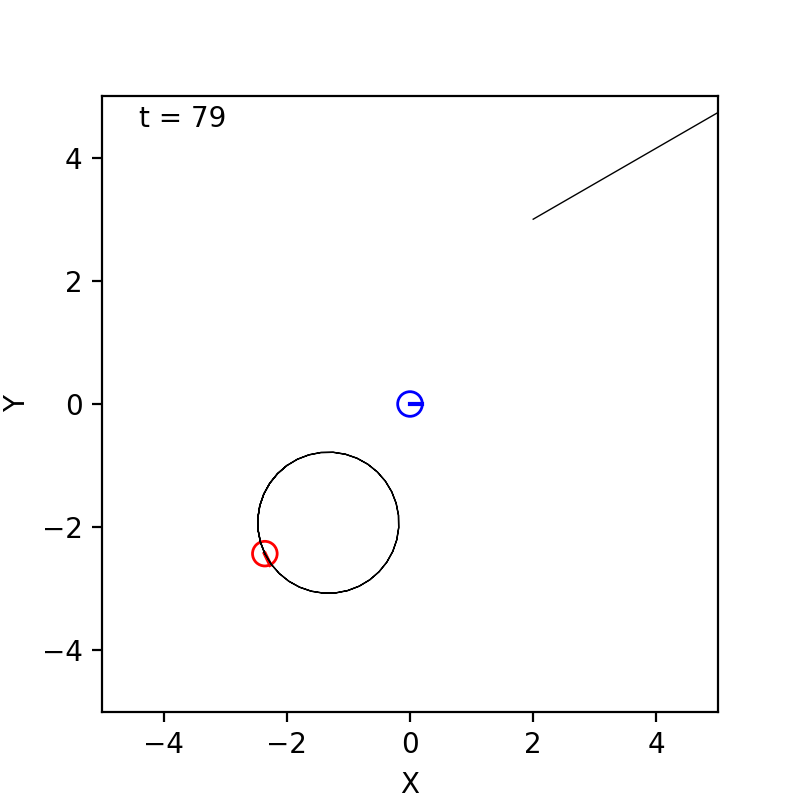

In [5]:
world = World()                                                                                                                       ### fig:rewrite_robot_for_agent
straight = Agent(0.2, 0.0)                # 0.2[m/s]で直進     
circling = Agent(0.2, 10.0/180*math.pi)   # 0.2[m/s], 10[deg/s]（円を描く）
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    straight )  
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, circling, "red")  
robot3 = IdealRobot( np.array([ 0, 0, 0]).T, color="blue")     # エージェントを与えないロボット
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()

In [6]:
## 原点から0.1[m/s]で1[s]直進 ##          ### fig:using_state_transition（セル6まで）
IdealRobot.state_transition(0.1, 0.0, 1.0, np.array([0,0,0]).T) 

array([0.1, 0. , 0. ])

array([0.1, 0. , 0. ])

In [7]:
## 原点から0.1[m/s], 10[deg/s]で9[s]移動 ## 
IdealRobot.state_transition(0.1, 10.0/180*math.pi, 9.0, np.array([0,0,0]).T)

In [8]:
## 原点から0.1[m/s], 10[deg/s]で18[s]移動 ##
IdealRobot.state_transition(0.1, 10.0/180*math.pi, 18.0, np.array([0,0,0]).T)